# Single-cell evidence enrichment analysis

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import json

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils
import upsetplot

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [7]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [51]:
%%R

### Plotting utils
evidence_labels <- c(
    "any" = "Any evidence", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "DE in disease", 
    "ct_marker_evidence" = "Cell type marker", 
    "has_genetic_support" = "Genetic association"
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    text_position='right',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'any')
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=rev(c('druggable', 'safe', 'effective', 'approved')))) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha)
    
    # Don't show values with no support
    max_OR <- max((pl_df[,'ci_high']))
    
    pl <- ggplot(pl_df, aes(y=clinical_status, x=odds_ratio, color=is_signif)) +
        geom_point(
            data = . %>% filter(n_supported_approved > 0),
            size=3
        ) +
        geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -0.1) , 
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        xlab('Odds Ratio') +
        ylab('Drug target class') +
        theme_classic(base_size=20) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

## Reproducing association with genetics evidence

In [9]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)

In [10]:
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

### Compute OR with different universe of targets

- All protein-coding genes
- All targets in OpenTargets
- All targets with known drugs
- All small-molecule tractable targets
- All antibody-tractable targets

In [11]:
## Get all disease IDs in scRNA-seq data
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_OT_targets.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_OT_targets.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]

In [12]:
len(all_disease_ids)

41

Make dictionary for all the universes (to use when the same universe is used for all diseases)

In [13]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

Run association testing

In [126]:
results_genetics_df = pd.DataFrame()
genetics_all_df = OT_targets_df.copy()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'all_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
        or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'cxg_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [127]:
# Variable universe x disease cases
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    ## All OT targets
    or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'OT_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'OT_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    ## Known drug OT targets
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.known_drug > 0], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[(genetics_all_df.known_drug > 0) & (genetics_all_df.disease_ontology_id.isin(all_disease_ids))], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

### plot results

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


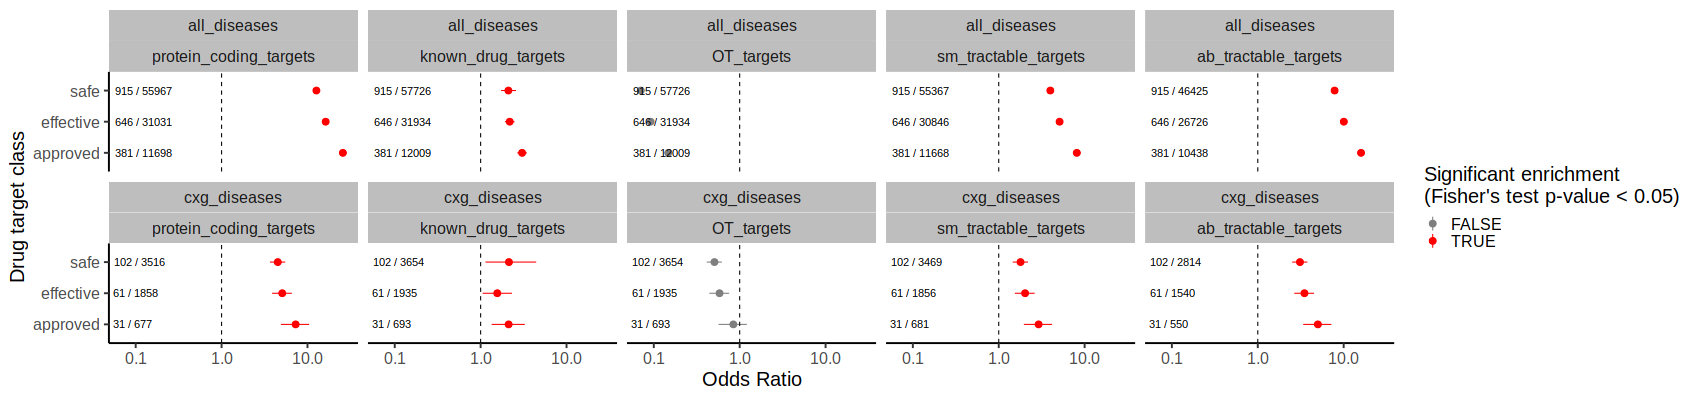

In [129]:
%%R -i results_genetics_df -w 1700 -h 400
results_genetics_df %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'known_drug_targets', 'OT_targets', 'sm_tractable_targets', 'ab_tractable_targets'))) %>%
    drop_na() %>%
    plot_OR(text_position='left') +
    facet_wrap(disease_ontology_id~universe, nrow=2) 

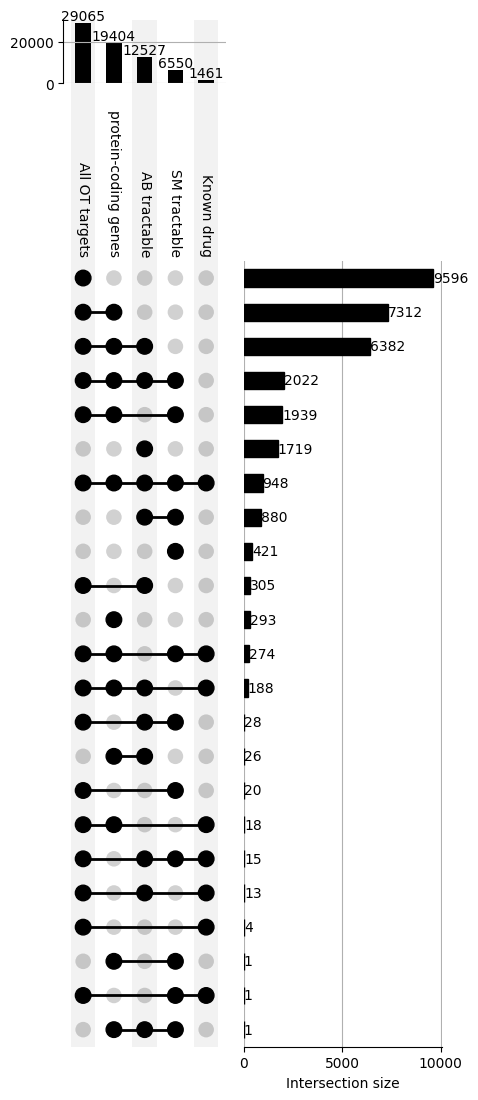

In [232]:
upset_dict = {'protein-coding genes':universe_dict['protein_coding_targets'],
    'SM tractable':universe_dict['sm_tractable_targets'],
    'AB tractable':universe_dict['ab_tractable_targets'],
     'Known drug':OT_targets_df[OT_targets_df.known_drug > 0].gene_id.unique().tolist(),
     'All OT targets': OT_targets_df.gene_id.unique().tolist()
    }
target_universe_upset = upsetplot.from_contents(upset_dict)

upsetplot.UpSet(
    target_universe_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality'
)

In [235]:
import json

json_file = data_dir + '/target_universe_dict.json'
with open(json_file, "w") as json_file:
    json.dump(universe_dict, json_file)

## Get single-cell evidence from DE results and merge with OT evidence 

In [170]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]

In [171]:
## Save evidence results for each disease
for disease_ontology_id in all_disease_ids:
    try:
        ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
        bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

        evidence_dict = sc_evidence_utils.DE2evidence_celltype(
            ct_res, ct_fraction_thresh=0.2, lfc_thresh=3.0, signif_thresh=0.1)
        disease_evidence = sc_evidence_utils.DE2evidence_disease(
            disease_res, bulk_res, lfc_thresh=1.0, lfc_group='all', signif_thresh=0.1)
        evidence_dict.update(disease_evidence)
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
        
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
        
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()
    
    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    targets_disease_df.to_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv')

missing MONDO_0005097
missing MONDO_0005249
missing MONDO_0005011
missing MONDO_0002771
missing MONDO_0015925
missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0100096
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0009061
missing MONDO_0018874
missing MONDO_0008433
missing MONDO_0004849
missing MONDO_0015759
missing MONDO_0005233
missing MONDO_0004970
missing MONDO_0005061
missing MONDO_0005812
missing MONDO_0005002
missing MONDO_0000709
missing MONDO_0024660
missing MONDO_0007915
missing MONDO_0015517


## Association statistics

Collect evidence and clinical status for all tested diseases.

In [172]:
targets_evidence_all = pd.DataFrame()

## For each disease
for disease_ontology_id in all_disease_ids:
    try:
        OT_targets_disease_df = pd.read_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv', index_col=0)
        OT_targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
        OT_targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
        targets_evidence_all = pd.concat([targets_evidence_all, OT_targets_disease_df], axis=0)
    except FileNotFoundError:
        continue
     
targets_evidence_all['any'] = (targets_evidence_all[['ct_marker_evidence', 'disease_ct_evidence', 'has_genetic_support']].sum(1) > 0).astype('int')
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

In [173]:
# Check number of diseases 
print(f"Tot. no of diseases considered: {targets_evidence_all['disease_ontology_id'].nunique()}")

Tot. no of diseases considered: 12


Compute odds-ratios for all diseases together with different universes

In [136]:
# OR_disease_df = compute_grouped_OR(targets_evidence_all, group_by = 'disease_ontology_id')
# OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ":")] for x in OR_disease_df.disease_ontology_id]
# OR_tissue_df = compute_grouped_OR(targets_evidence_all, group_by = 'disease_relevant_tissue')

In [163]:
results_all_df = pd.DataFrame()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

Add variable universe x disease cases

In [164]:
# Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].copy()
# Merge with sc evidence (keeping just OT targets)
OT_targets_test_df = pd.merge(OT_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
        ## All OT targets
        or_df = association_utils.get_OR(OT_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'OT_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [165]:
# Get all known drug OT targets for selected diseases 
known_drug_targets_test_df = OT_targets_df[
    (OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & \
    (OT_targets_df['known_drug'] > 0)
].copy()

# Merge with sc evidence (keeping just OT targets)
known_drug_targets_test_df = pd.merge(known_drug_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support', 'any']:
        ## All OT targets
        or_df = association_utils.get_OR(known_drug_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'known_drug_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

## Plot results

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


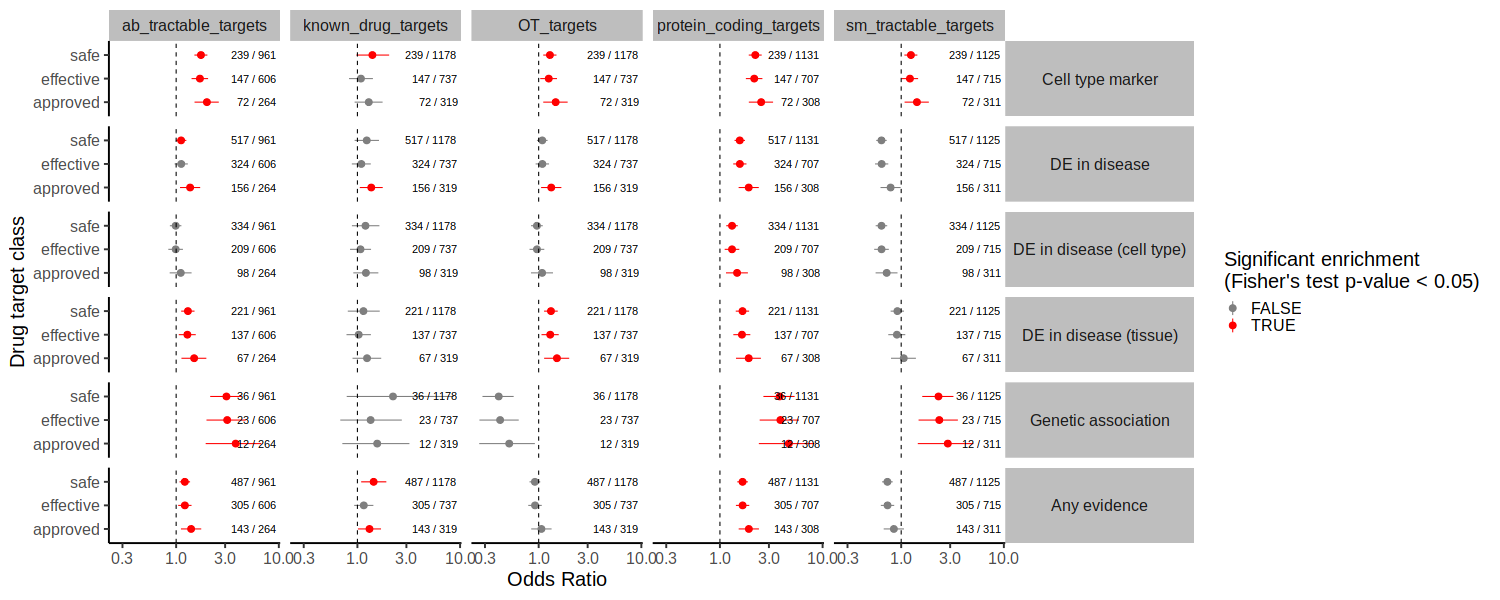

In [166]:
%%R -i results_all_df -w 1500 -h 600
plot_OR(results_all_df, text_position='right') +
facet_grid(evidence~universe, 
           labeller = labeller(evidence=as_labeller(evidence_labels))
          ) 

## Test combination of genetic and single-cell support

In [167]:
for sc_evidence in ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence']:
    targets_evidence_all[f'genetic_and_{sc_evidence}'] = ((targets_evidence_all['has_genetic_support'] == 1) & (targets_evidence_all[sc_evidence] == 1)).astype(int)

In [168]:
results_all_df = pd.DataFrame()
evidence_cols =  ['has_genetic_support', 'genetic_and_disease_ct_evidence', 'genetic_and_ct_marker_evidence', 'genetic_and_disease_evidence']

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

# Get all OT targets for selected diseases 
OT_targets_test_df = OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].copy()
# Merge with sc evidence (keeping just OT targets)
OT_targets_test_df = pd.merge(OT_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in evidence_cols:
        ## All OT targets
        or_df = association_utils.get_OR(OT_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'OT_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

# Get all known drug OT targets for selected diseases 
known_drug_targets_test_df = OT_targets_df[
    (OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & \
    (OT_targets_df['known_drug'] > 0)
].copy()

# Merge with sc evidence (keeping just OT targets)
known_drug_targets_test_df = pd.merge(known_drug_targets_test_df, targets_evidence_all, how='left').fillna(0)

for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in evidence_cols:
        ## All OT targets
        or_df = association_utils.get_OR(known_drug_targets_test_df, ev, ot_ev)
        or_df['universe'] = 'known_drug_targets'
        results_all_df = pd.concat([results_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


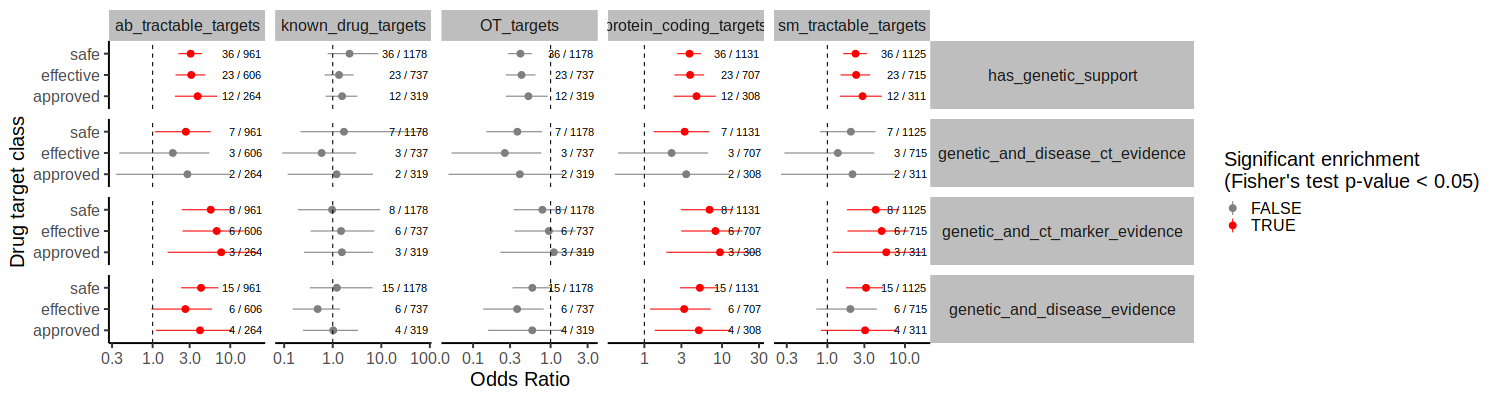

In [169]:
%%R -i results_all_df -i evidence_cols -w 1500 -h 400
plot_OR(results_all_df, text_position='right', 
        evidence_levels = evidence_cols) +
facet_grid(evidence~universe, scale='free_x'
#            labeller = labeller(evidence=as_labeller(evidence_labels))
          ) 

### Overlap between evidence sets

In [144]:
targets_evidence_all['target_disease'] = targets_evidence_all['gene_id'] + "_" + targets_evidence_all['disease_ontology_id']

In [145]:
targets_evidence_all['target_disease'].nunique()

95089

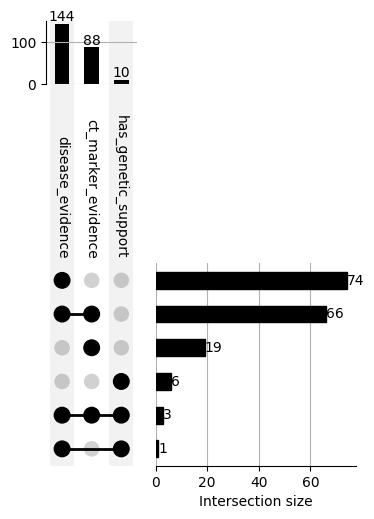

In [157]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_evidence_all.target_disease[(targets_evidence_all[ev] == 1) & (targets_evidence_all.is_approved == 1)].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality'
)

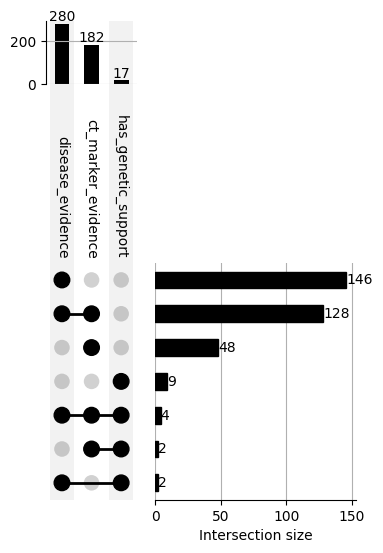

In [158]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
evidence_sets_dict = {}
for ev in evidence_cols:
    evidence_sets_dict[ev] = targets_evidence_all.target_disease[(targets_evidence_all[ev] == 1) & (targets_evidence_all.is_effective == 1)].tolist()

evidence_upset = upsetplot.from_contents(evidence_sets_dict)

upsetplot.UpSet(
    evidence_upset, 
    orientation='vertical', 
    show_counts = '{:d}', 
    sort_categories_by='cardinality',
    sort_by='cardinality'
)

## Stratified OR

In [23]:
n_safe_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()['is_safe']
test_diseases = n_safe_x_disease.index[n_safe_x_disease > 0]

/tmp/ipykernel_8023/3498937683.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_safe_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()['is_safe']


In [37]:
OR_disease_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all['disease_ontology_id'].isin(test_diseases)], 
    group_by = 'disease_ontology_id', 
    evidence_cols = ['disease_ct_evidence', 'ct_marker_evidence', 'disease_evidence','bulk_disease_evidence', 'has_genetic_support'],
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

In [38]:
OR_disease_df['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]
OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]

In [39]:
disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


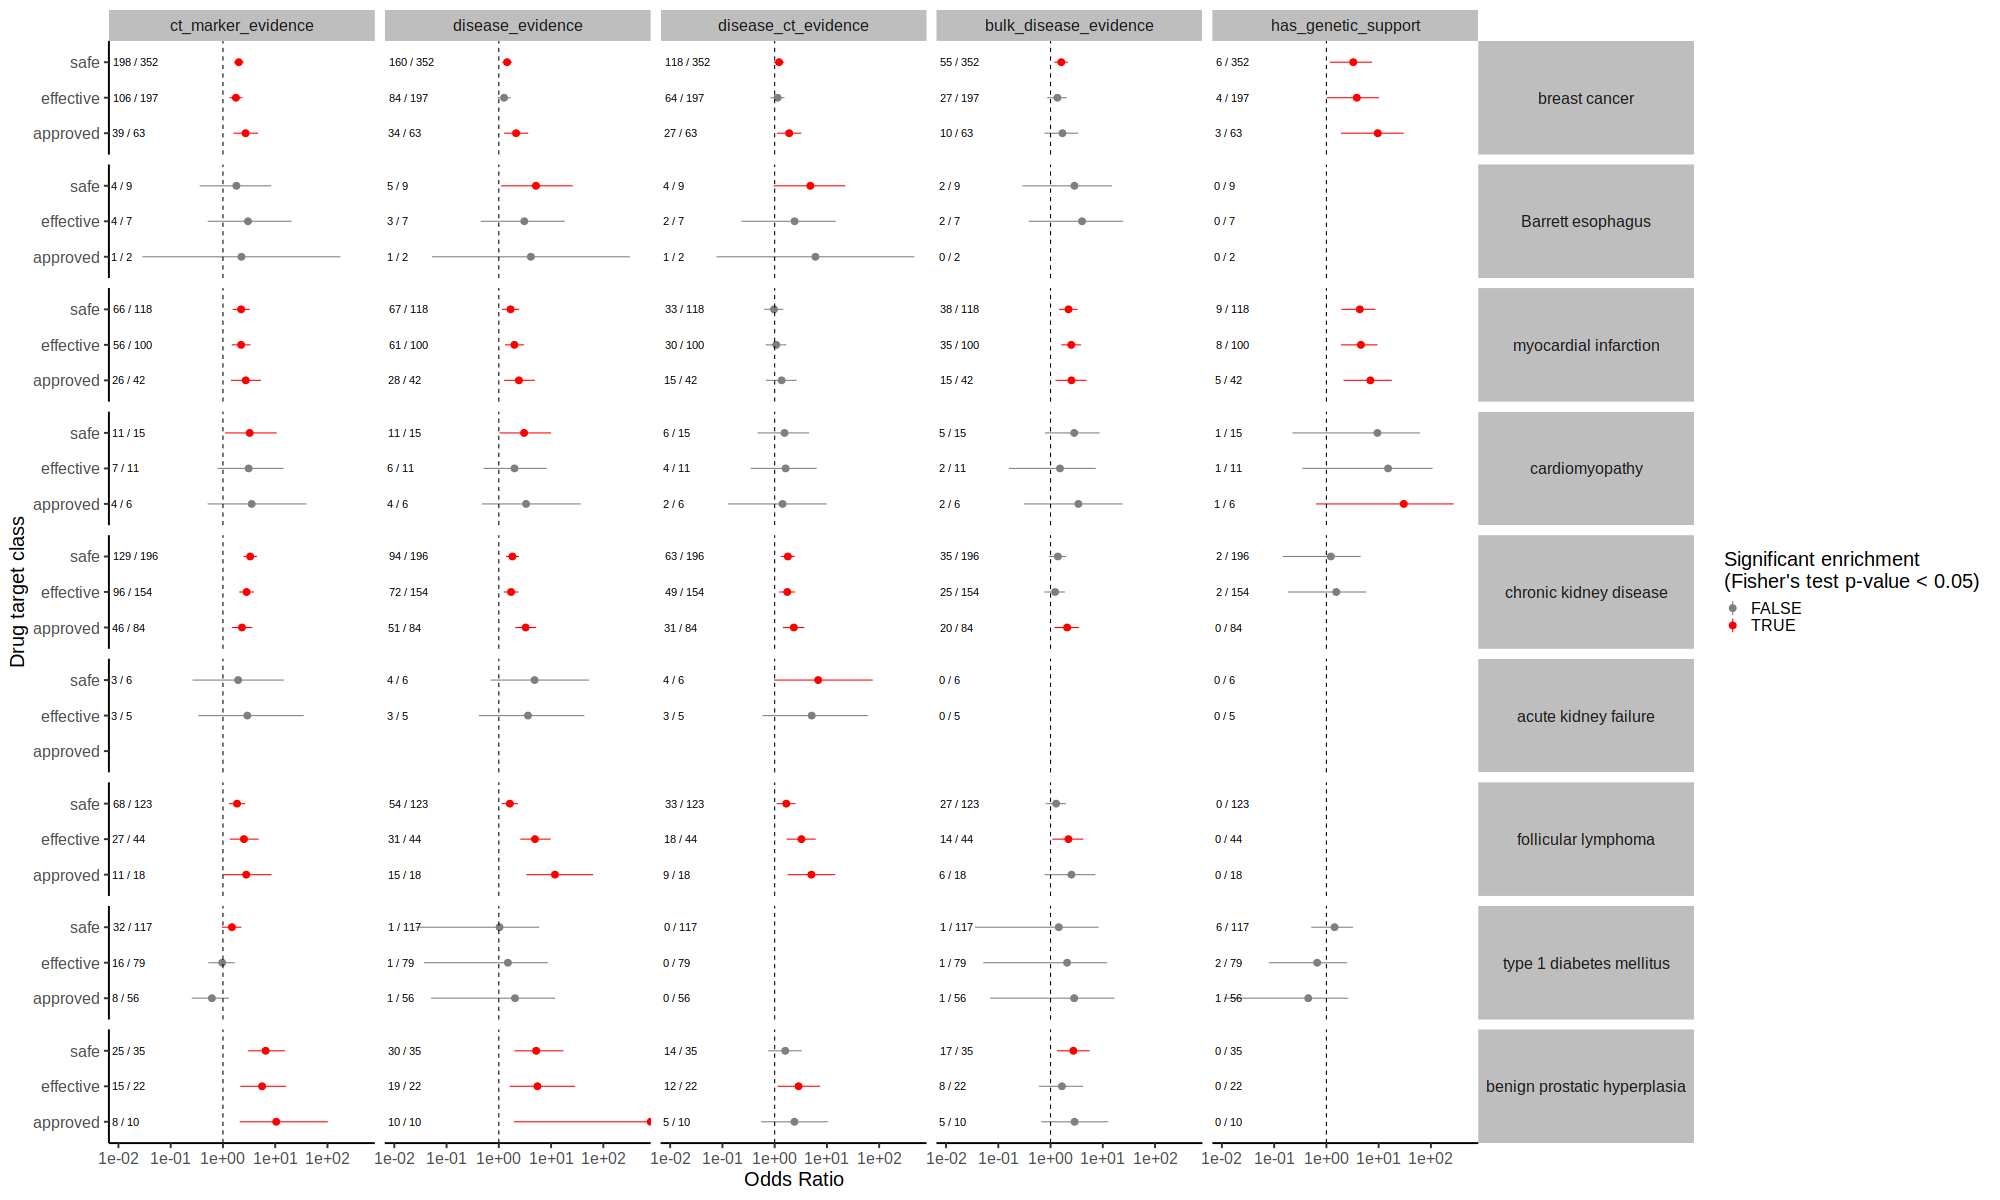

In [41]:
%%R -i OR_disease_df -h 1200 -w 2000 -i disease_order

OR_disease_df <- mutate(OR_disease_df, disease = factor(disease, levels=as.list(disease_order))) 

plot_OR(OR_disease_df, 
        text_position='left') +
    facet_grid(disease~evidence, 
               labeller = labeller(sc_evidence = as_labeller(evidence_labels))) 

In [1196]:
# %%R -i OR_disease_drug_df -h 1500 -w 1800 -i disease_order

# OR_disease_drug_df <- mutate(OR_disease_drug_df, disease = factor(disease, levels=as.list(disease_order))) 


# plot_OR(OR_disease_drug_df, 
#         text_position='left') +
#     facet_grid(disease~sc_evidence, 
#                labeller = labeller(sc_evidence = as_labeller(evidence_labels))) 

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


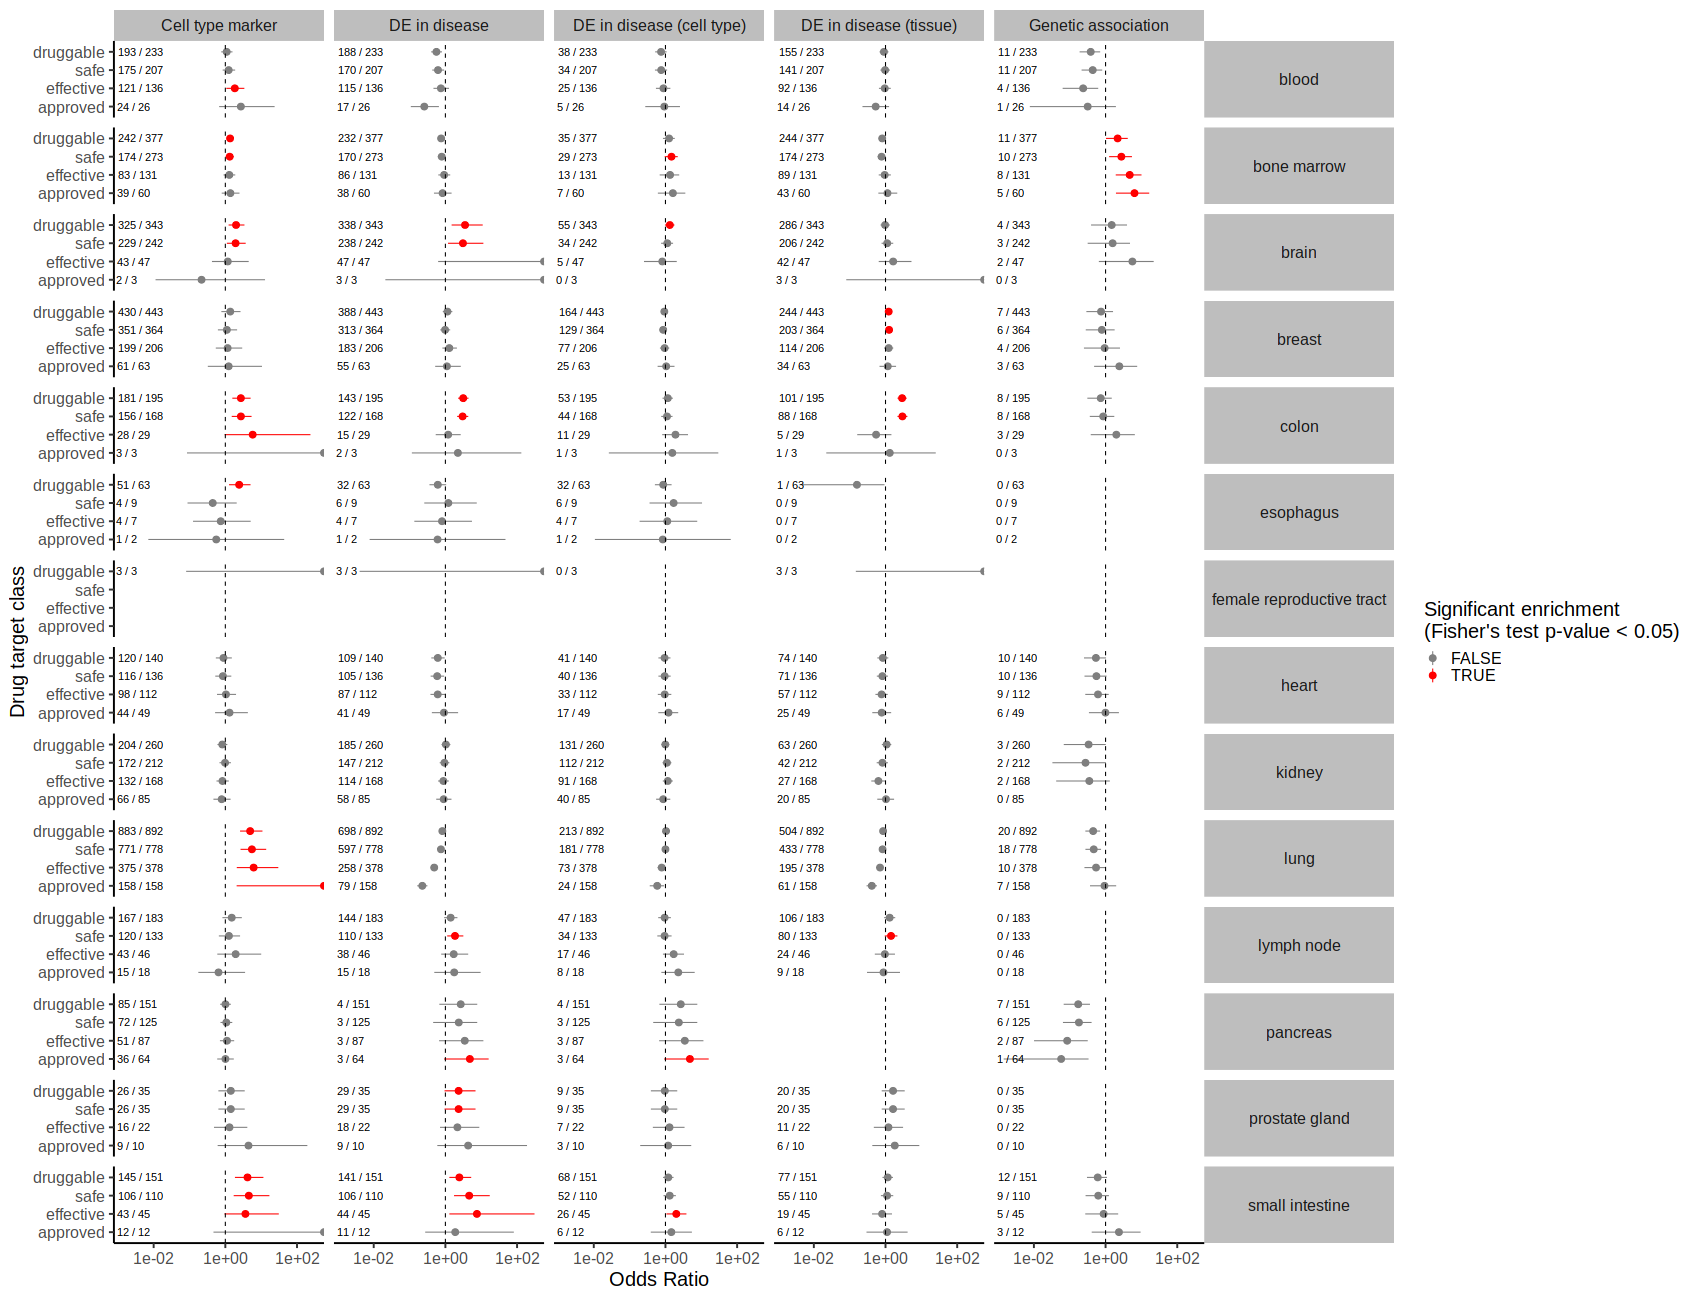

In [1197]:
%%R -i OR_tissue_df -h 1300 -w 1700 

plot_OR(OR_tissue_df,  text_position='left') +
    facet_grid(disease_relevant_tissue~sc_evidence, 
               labeller = labeller(sc_evidence = as_labeller(evidence_labels))) 

## Test dependency on lfc and fraction of cell type in marker genes

In [1386]:
def get_celltype_marker_evidence_from_DE(
    disease_ontology_id: str, 
    data_dir: str = "/nfs/team205/ed6/bin/sc_target_evidence/data/",
    signif_thresh: float = 0.1,
    lfc_thresh = 1,
    ct_fraction_thresh = 0.5
    ):
    '''Get targets with sc evidence from DE analysis results.'''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id}.all_targets.csv')
    ct_res['disease_ontology_id'] = disease_ontology_id

    evidence_dict = {}

    # Are the target genes cell type markers (significantly over-expressed in a subset of cell types)
    ct_marker_evidence_df = ct_res[
        (ct_res['adj_pval'] < signif_thresh) & (ct_res['lfc'] > lfc_thresh)
        ].groupby('gene_id').size()/tot_celltypes
    evidence_dict['ct_marker_evidence'] = ct_marker_evidence_df.index[ct_marker_evidence_df < ct_fraction_thresh].values
    return(evidence_dict)


targets_evidence_all_lfc = pd.DataFrame()
for min_lfc in [0.1, 1,2, 3,4,5]:
    for max_ct_frac in [0.25, 0.5, 0.75]:
        for disease_ontology_id in all_disease_ids:
            try:
                evidence_dict = get_celltype_marker_evidence_from_DE(disease_ontology_id, lfc_thresh = min_lfc, ct_fraction_thresh=max_ct_frac)
            except:
                continue
            OT_targets_disease_df = OT_targets_df[OT_targets_df['disease_ontology_id'] == disease_ontology_id].copy()
            for ev, targets in evidence_dict.items():
                OT_targets_disease_df[ev] = OT_targets_disease_df.gene_id.isin(targets).astype(int)

            OT_targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
            OT_targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
            OT_targets_disease_df['has_genetic_support'] = (OT_targets_disease_df['genetic_association'] > 0).astype(int)
            OT_targets_disease_df['min_lfc'] = min_lfc
            OT_targets_disease_df['max_ct_frac'] = max_ct_frac
            targets_evidence_all_lfc = pd.concat([targets_evidence_all_lfc, OT_targets_disease_df], axis=0)


targets_evidence_all_lfc


,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,is_approved,has_genetic_evidence,has_been_pursued,ct_marker_evidence,disease,disease_relevant_tissue,has_genetic_support,min_lfc,max_ct_frac
13391,ENSG00000005381,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,0,Crohn ileitis,small intestine,0,0.1,0.25
18670,ENSG00000006128,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,1,Crohn ileitis,small intestine,0,0.1,0.25
24471,ENSG00000007171,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,0,Crohn ileitis,small intestine,0,0.1,0.25
28556,ENSG00000007908,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,1,Crohn ileitis,small intestine,0,0.1,0.25
37613,ENSG00000010610,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,0,Crohn ileitis,small intestine,0,0.1,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044368,ENSG00000288825,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2044620,ENSG00000289746,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2044963,ENSG00000290788,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2045354,ENSG00000291135,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75


In [1387]:
# n_targets = targets_evidence_all_lfc.groupby(['min_lfc', 'disease', 'disease_relevant_tissue']).count().reset_index()[['min_lfc', 'disease','disease_relevant_tissue' ,'gene_id']]
# n_targets.columns = ['min_lfc', 'disease','disease_relevant_tissue' , 'n_targets']
# n_evidence = targets_evidence_all_lfc.groupby(['min_lfc', 'disease', 'disease_relevant_tissue']).sum().reset_index()[['min_lfc', 'disease','disease_relevant_tissue' , 'ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence']]
# pl_n_targets = pd.merge(n_evidence, n_targets)
# pl_n_targets

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


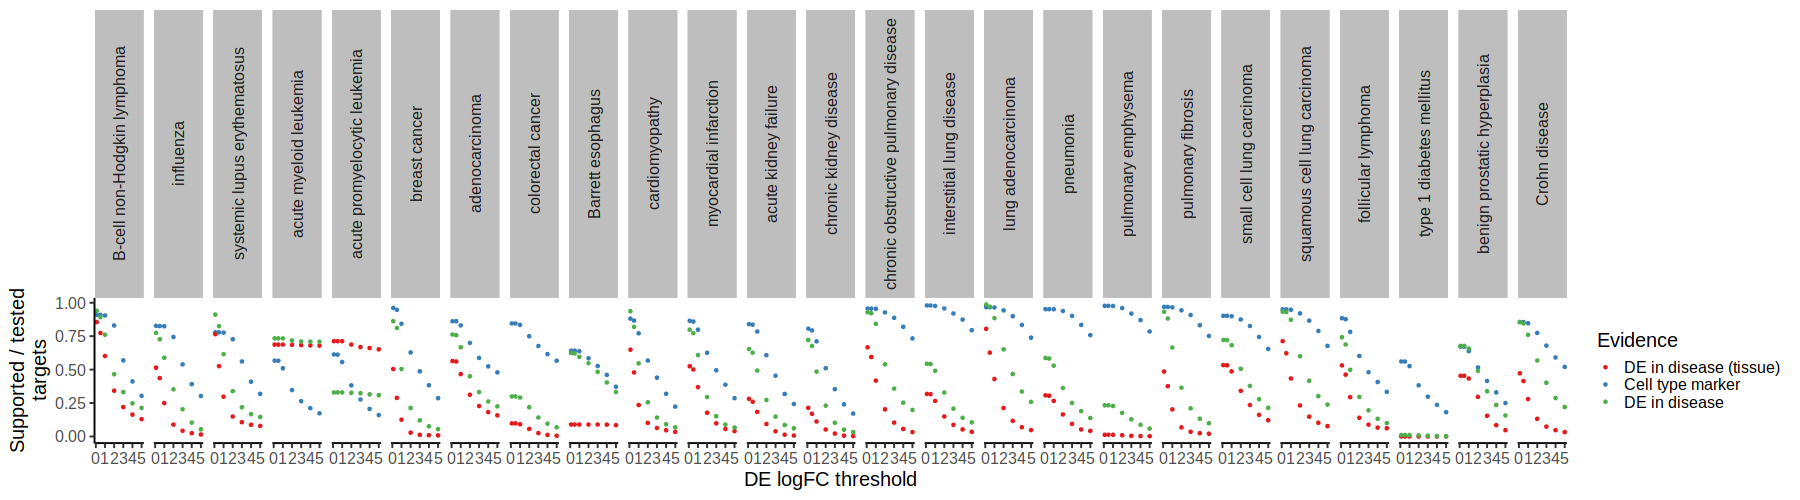

In [1166]:
%%R -i pl_n_targets -w 1800 -h 500
pl_n_targets %>%
pivot_longer(cols = - c(disease, disease_relevant_tissue, min_lfc, n_targets), names_to='sc_evidence', values_to='n_supported_targets') %>%
arrange(disease_relevant_tissue) %>%
mutate(disease = factor(disease, levels=unique(disease))) %>%
ggplot(aes(min_lfc, n_supported_targets/n_targets, color=sc_evidence)) +
geom_point() +
facet_wrap(disease~., nrow=1) +
theme_classic(base_size=20) +
ylab('Supported / tested\ntargets') +
xlab('DE logFC threshold') +
scale_color_brewer(palette='Set1', labels=evidence_labels, name='Evidence') +
theme(strip.text.x=element_text(angle=90), strip.background = element_rect(color=NA, fill = "grey"))  

In [1388]:
targets_evidence_all_lfc['group_by'] = targets_evidence_all_lfc['min_lfc'].astype('str') + targets_evidence_all_lfc['max_ct_frac'].astype('str')

In [1389]:
lfc_OR = compute_grouped_OR(targets_evidence_all_lfc, group_by = 'group_by')

In [1390]:
lfc_OR['min_lfc'] = lfc_OR['group_by'].str[0:3].astype('float')
lfc_OR['max_ct_frac'] = lfc_OR['group_by'].str[3:6].astype('float')
lfc_OR

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,sc_evidence,ot_evidence,group_by,min_lfc,max_ct_frac
0,1.092362,1.019890,1.169708,0.005783,3655.0,83702.0,1426.0,32341.0,ct_marker_evidence,is_druggable,0.10.25,0.1,0.2
0,1.065625,0.987340,1.149756,0.051496,2956.0,84401.0,1137.0,32341.0,ct_marker_evidence,is_safe,0.10.25,0.1,0.2
0,1.051992,0.945489,1.169728,0.178821,1503.0,85854.0,574.0,32341.0,ct_marker_evidence,is_effective,0.10.25,0.1,0.2
0,1.044604,0.878963,1.239242,0.319640,581.0,86776.0,221.0,32341.0,ct_marker_evidence,is_approved,0.10.25,0.1,0.2
0,0.474570,0.386618,0.577108,1.000000,3655.0,83702.0,106.0,5062.0,has_genetic_support,is_druggable,0.10.25,0.1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.738583,0.617402,0.881095,0.999776,581.0,86776.0,190.0,34626.0,ct_marker_evidence,is_approved,5.00.75,5.0,0.7
0,0.474570,0.386618,0.577108,1.000000,3655.0,83702.0,106.0,5062.0,has_genetic_support,is_druggable,5.00.75,5.0,0.7
0,0.531032,0.427354,0.652984,1.000000,2956.0,84401.0,95.0,5062.0,has_genetic_support,is_safe,5.00.75,5.0,0.7
0,0.613313,0.459039,0.804240,0.999944,1503.0,85854.0,55.0,5062.0,has_genetic_support,is_effective,5.00.75,5.0,0.7


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


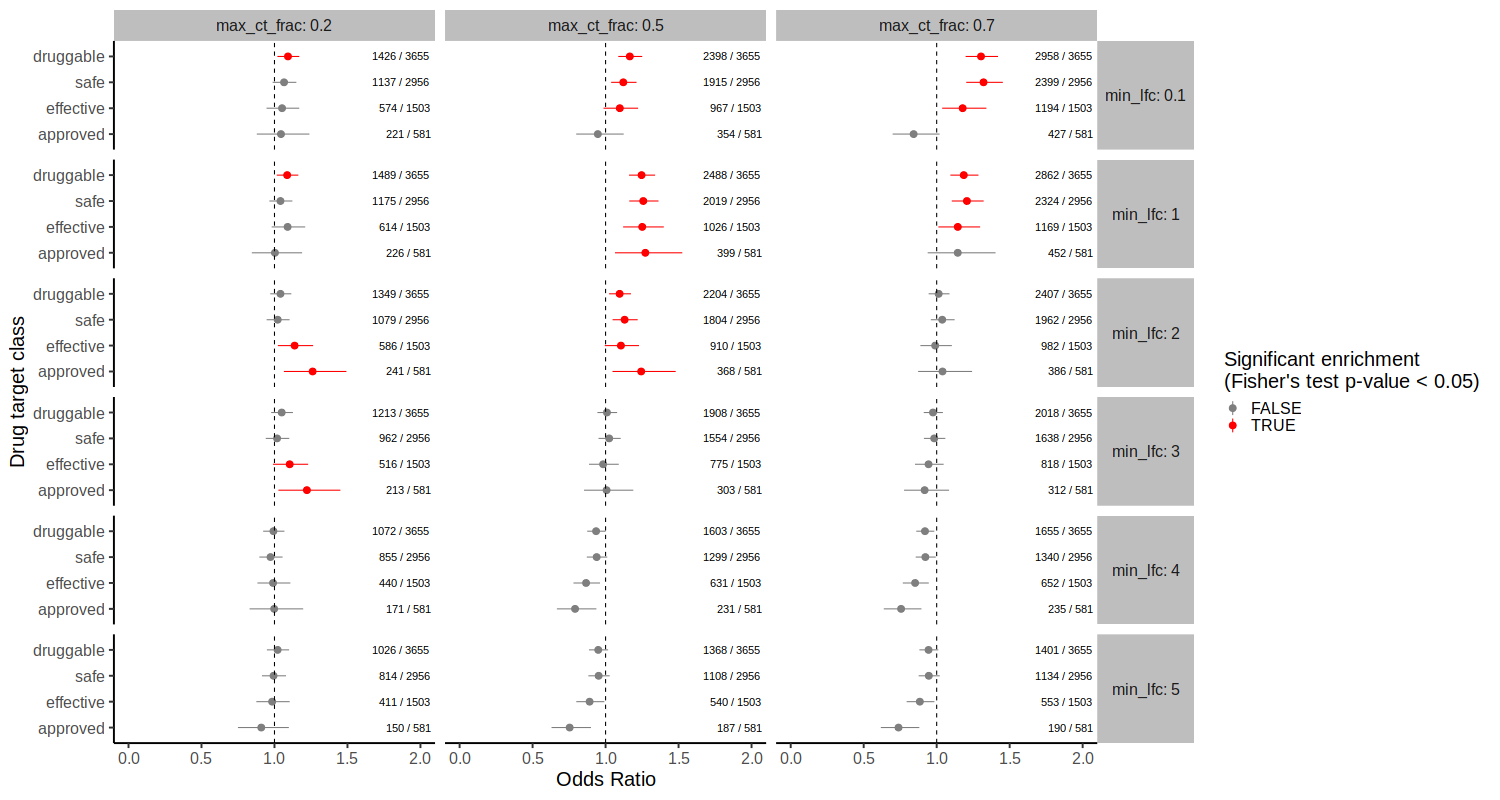

In [1393]:
%%R -i lfc_OR -w 1500 -h 800
plot_OR(lfc_OR %>% filter(!sc_evidence %in% c('has_genetic_support'))) +
 facet_grid(min_lfc~max_ct_frac, 
               labeller = 'label_both') +
    xlim(0,2)


In [1402]:
def get_disease_evidence_from_DE(
    disease_ontology_id: str, 
    data_dir: str = "/nfs/team205/ed6/bin/sc_target_evidence/data/",
    signif_thresh: float = 0.1,
    lfc_thresh = 1,
    abs_lfc = True
    ):
    '''Get targets with sc evidence from DE analysis results.'''
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id}.all_targets.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id}.all_targets.csv')

    ct_res['disease_ontology_id'] = disease_ontology_id
    disease_res['disease_ontology_id'] = disease_ontology_id
    bulk_res['disease_ontology_id'] = disease_ontology_id

    evidence_dict = {}

    # Are the target genes differentially expressed between disease and control in a subset of cell types (and not detectable in bulk)?
    evidence_dict['bulk_disease_evidence'] = bulk_res[
        (bulk_res['adj_pval'] < signif_thresh) & (np.abs(bulk_res['lfc']) > lfc_thresh)
        ].gene_id.unique()

    evidence_dict['disease_evidence'] = disease_res[
        (disease_res['adj_pval'] < signif_thresh) & (np.abs(disease_res['lfc']) > lfc_thresh)
        ].gene_id.unique()
    
    evidence_dict['disease_ct_evidence'] = np.setdiff1d(evidence_dict['disease_evidence'], evidence_dict['bulk_disease_evidence'])

    evidence_dict['bulk_disease_evidence_overexpressed'] = bulk_res[
            (bulk_res['adj_pval'] < signif_thresh) & (bulk_res['lfc'] > lfc_thresh)
            ].gene_id.unique()

    evidence_dict['disease_evidence_overexpressed'] = disease_res[
            (disease_res['adj_pval'] < signif_thresh) & (disease_res['lfc'] > lfc_thresh)
            ].gene_id.unique()
    
    evidence_dict['disease_ct_evidence_overexpressed'] = np.setdiff1d(evidence_dict['disease_evidence_overexpressed'], evidence_dict['bulk_disease_evidence_overexpressed'])

    return(evidence_dict)

In [1403]:
targets_evidence_all_lfc = pd.DataFrame()
for min_lfc in [0.1, 0.5, 1, 2, 3,4,5]:
    for disease_ontology_id in all_disease_ids:
        try:
            evidence_dict = get_disease_evidence_from_DE(disease_ontology_id, lfc_thresh = min_lfc)
        except:
            continue
        OT_targets_disease_df = OT_targets_df[OT_targets_df['disease_ontology_id'] == disease_ontology_id].copy()
        for ev, targets in evidence_dict.items():
            OT_targets_disease_df[ev] = OT_targets_disease_df.gene_id.isin(targets).astype(int)

        OT_targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
        OT_targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
        OT_targets_disease_df['has_genetic_support'] = (OT_targets_disease_df['genetic_association'] > 0).astype(int)
        OT_targets_disease_df['min_lfc'] = min_lfc
        OT_targets_disease_df['max_ct_frac'] = max_ct_frac
        targets_evidence_all_lfc = pd.concat([targets_evidence_all_lfc, OT_targets_disease_df], axis=0)


targets_evidence_all_lfc

,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,is_approved,has_genetic_evidence,has_been_pursued,...,disease_evidence,disease_ct_evidence,bulk_disease_evidence_overexpressed,disease_evidence_overexpressed,disease_ct_evidence_overexpressed,disease,disease_relevant_tissue,has_genetic_support,min_lfc,max_ct_frac
13391,ENSG00000005381,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,Crohn ileitis,small intestine,0,0.1,0.75
18670,ENSG00000006128,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,Crohn ileitis,small intestine,0,0.1,0.75
24471,ENSG00000007171,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,...,1,0,0,1,1,Crohn ileitis,small intestine,0,0.1,0.75
28556,ENSG00000007908,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,...,1,1,0,1,1,Crohn ileitis,small intestine,0,0.1,0.75
37613,ENSG00000010610,MONDO_0000709,0.0,0.0,0,0,0,0,0,0,...,1,0,1,1,0,Crohn ileitis,small intestine,0,0.1,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044368,ENSG00000288825,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2044620,ENSG00000289746,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2044963,ENSG00000290788,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75
2045354,ENSG00000291135,MONDO_0007915,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,systemic lupus erythematosus,blood,0,5.0,0.75


In [1436]:
lfc_OR = compute_grouped_OR(targets_evidence_all_lfc, group_by = 'min_lfc', 
                            sc_evidence_cols=['bulk_disease_evidence',
       'disease_evidence', 'disease_ct_evidence',
       'bulk_disease_evidence_overexpressed', 'disease_evidence_overexpressed',
       'disease_ct_evidence_overexpressed'])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


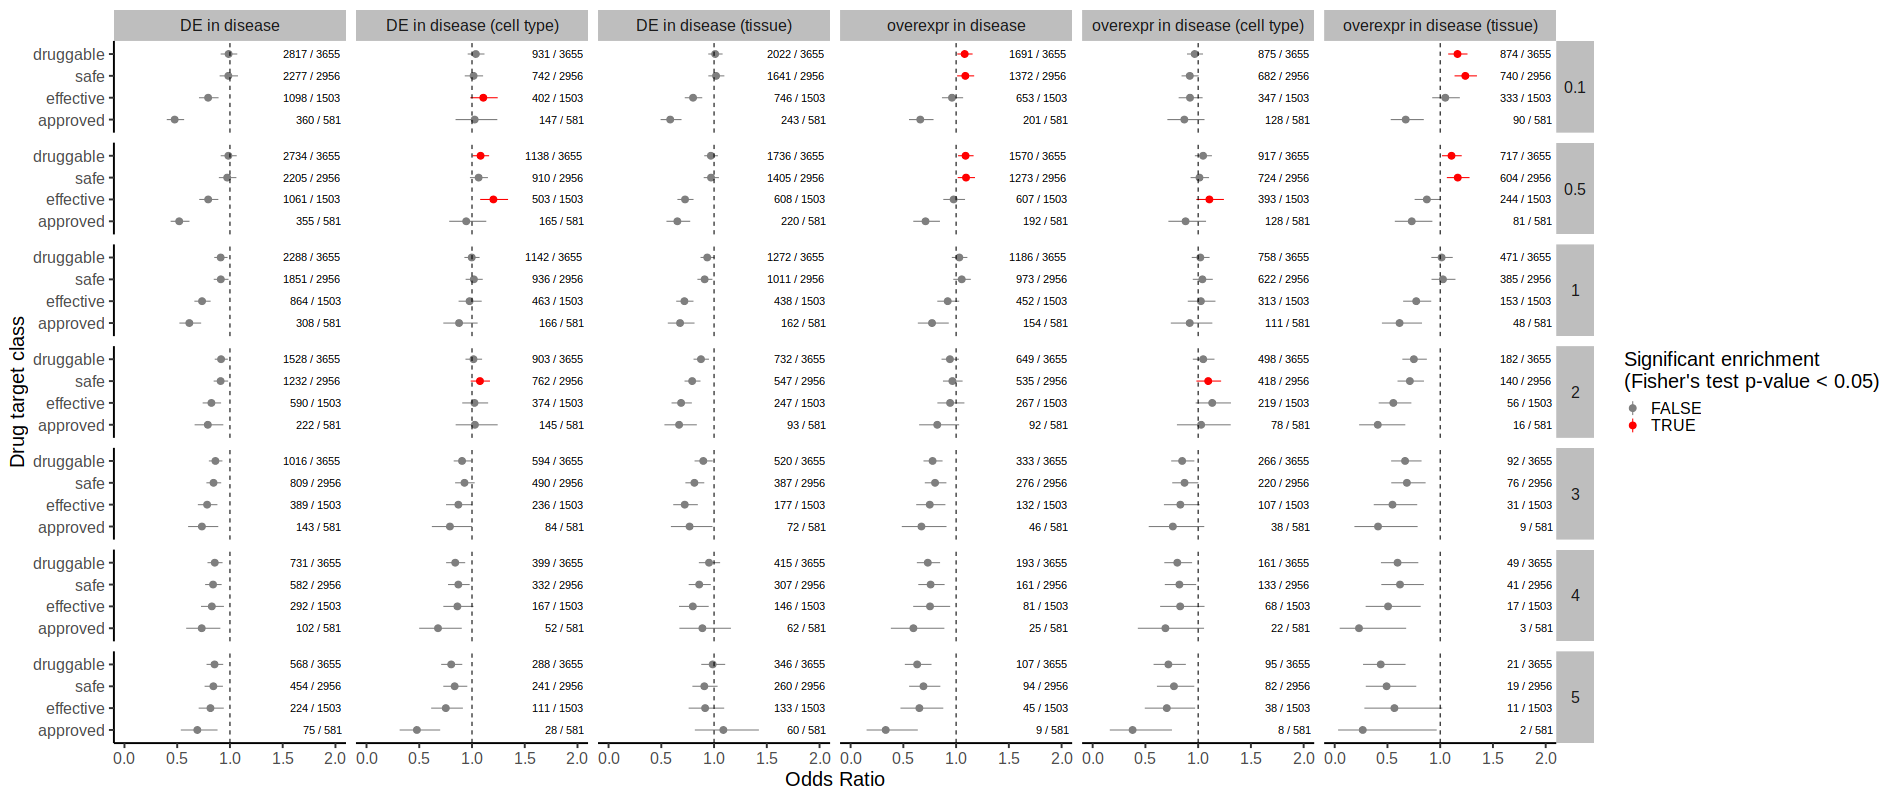

In [1419]:
%%R -i lfc_OR -w 1900 -h 800

evidence_labels <- c(
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "DE in disease", 
    "bulk_disease_evidence_overexpressed" = "overexpr in disease (tissue)", 
    "disease_ct_evidence_overexpressed" = "overexpr in disease (cell type)", 
    "disease_evidence_overexpressed" = "overexpr in disease"
    )


plot_OR(lfc_OR %>% filter(!sc_evidence %in% c('has_genetic_support'))) +
 facet_grid(min_lfc~sc_evidence, 
               labeller = labeller(sc_evidence = as_labeller(evidence_labels))) +
    xlim(0,2)


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


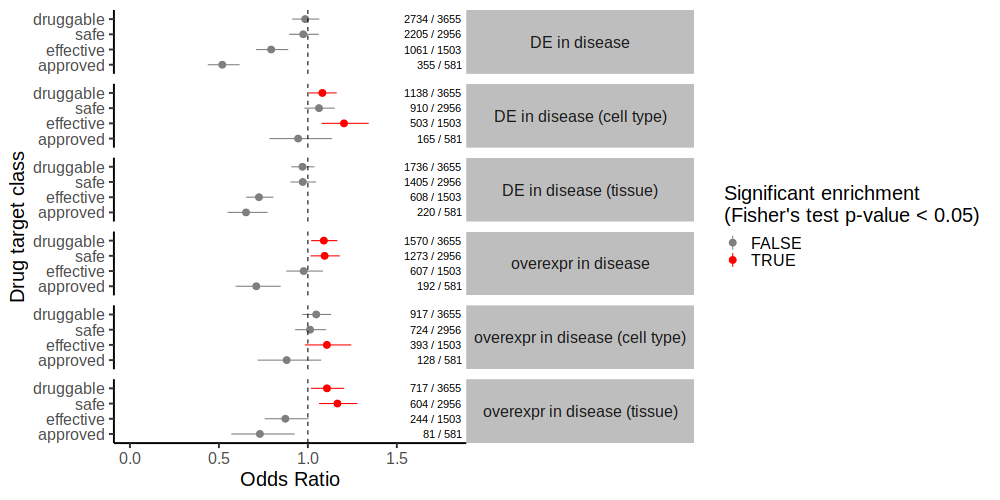

In [1443]:
%%R -i lfc_OR -w 1000 -h 500

plot_OR(lfc_OR %>% 
        filter(!sc_evidence %in% c('has_genetic_support')) %>%
        filter(min_lfc == 0.5)) +
 facet_grid(sc_evidence~., 
               labeller = labeller(sc_evidence = as_labeller(evidence_labels))) +
    xlim(0,1.8)


In [1421]:
lfc_OR = compute_grouped_OR(
    targets_evidence_all_lfc[targets_evidence_all_lfc.min_lfc == 0.5], 
    group_by = 'disease_relevant_tissue', 
    sc_evidence_cols=['bulk_disease_evidence',
       'disease_evidence', 'disease_ct_evidence',
       'bulk_disease_evidence_overexpressed', 'disease_evidence_overexpressed',
       'disease_ct_evidence_overexpressed'])

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


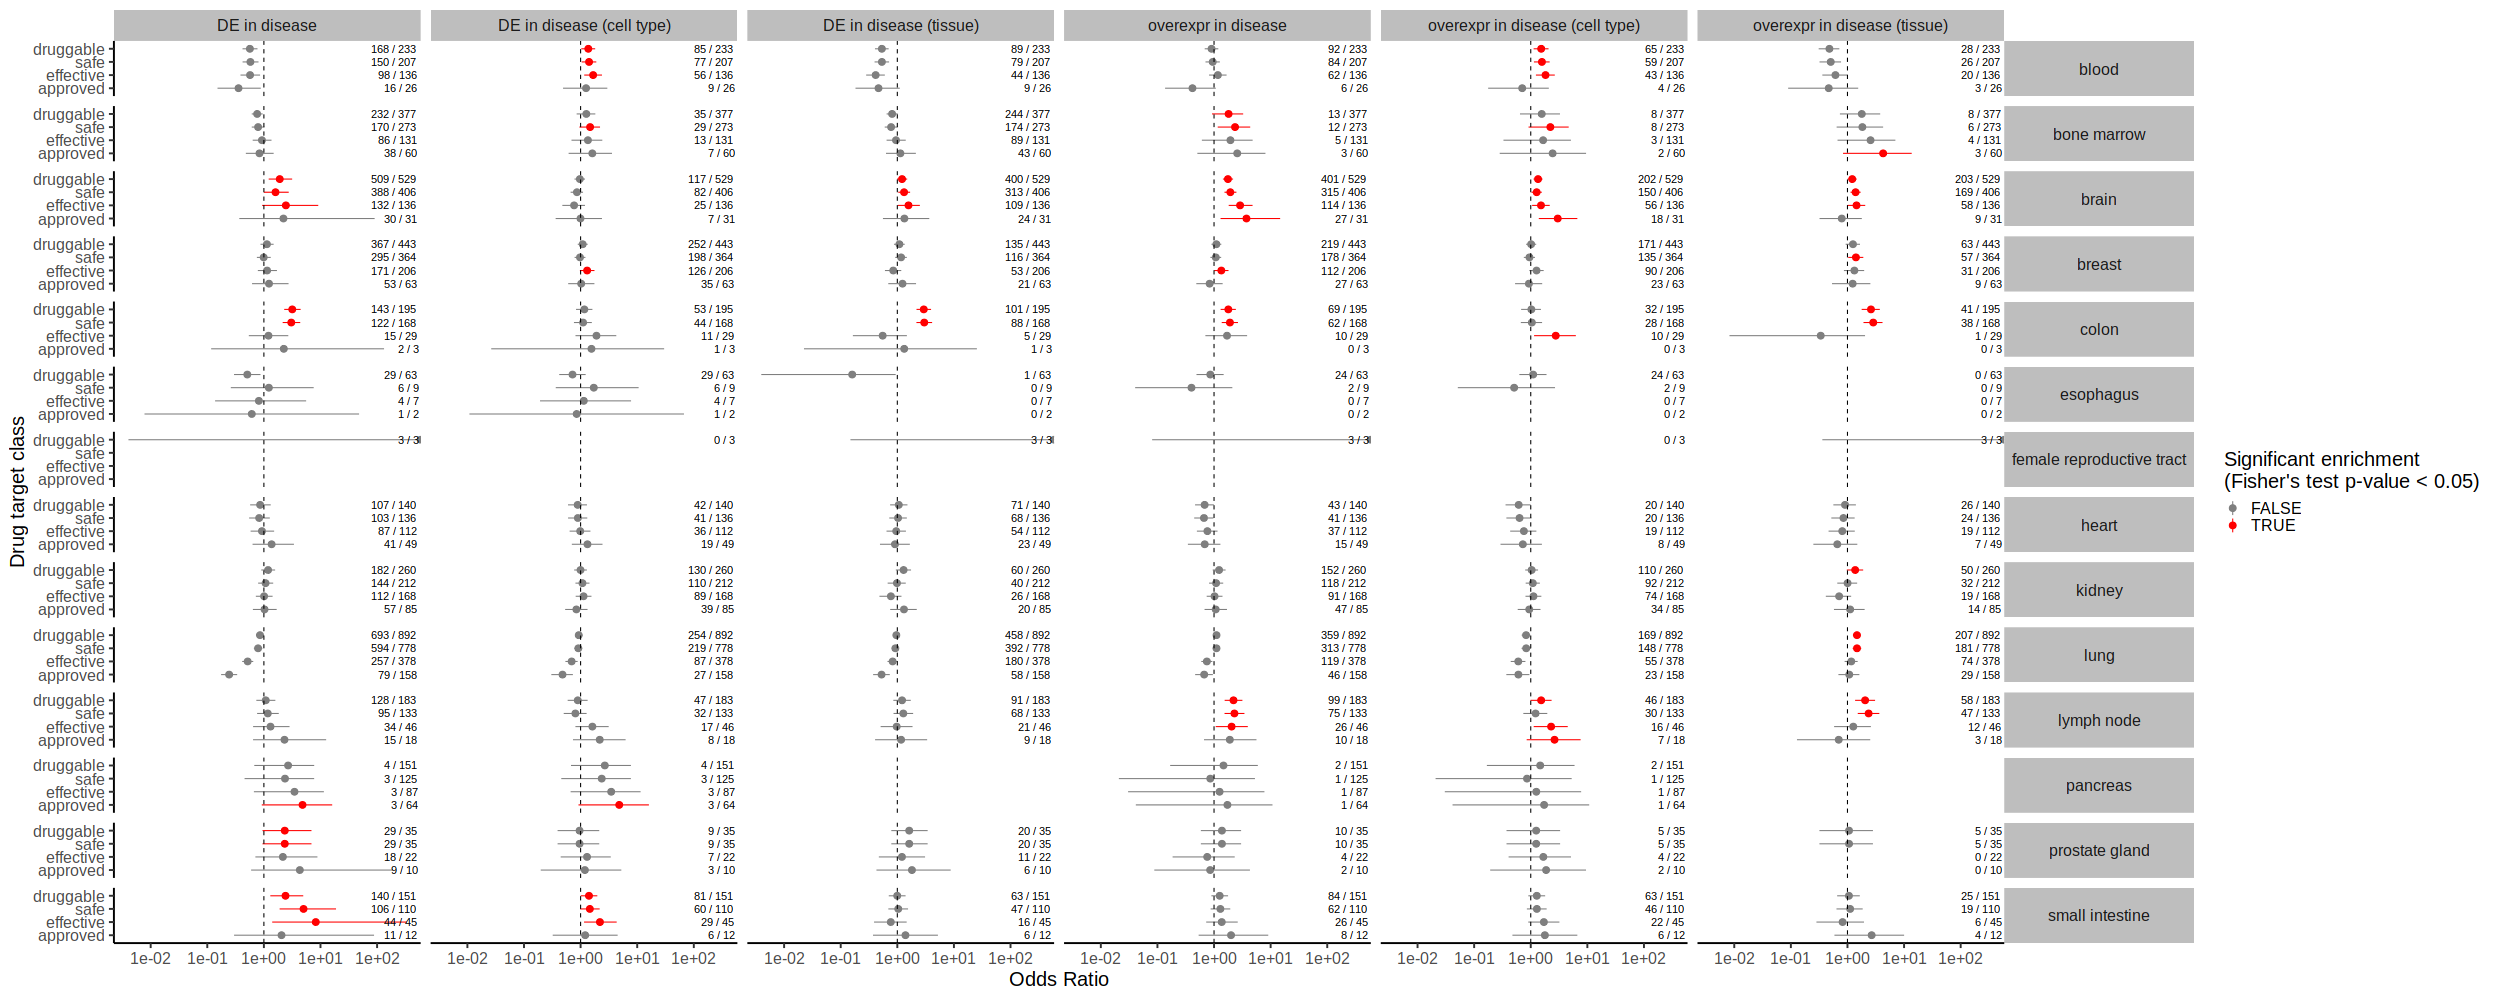

In [1433]:
%%R -i lfc_OR -w 2500 -h 1000

evidence_labels <- c(
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "DE in disease", 
    "bulk_disease_evidence_overexpressed" = "overexpr in disease (tissue)", 
    "disease_ct_evidence_overexpressed" = "overexpr in disease (cell type)", 
    "disease_evidence_overexpressed" = "overexpr in disease"
    )


plot_OR(lfc_OR) +
 facet_grid(disease_relevant_tissue ~ sc_evidence, 
               labeller = labeller(sc_evidence = as_labeller(evidence_labels))) +
ggsave('~/DE_evidence.png', width=28, height=15)


---
Check data from Nelson

In [1446]:
nelson_table = pd.read_table('./data/nelson_2023/merge2.tsv')

/tmp/ipykernel_262/314811441.py:1: DtypeWarning: Columns (17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  nelson_table = pd.read_table('./data/nelson_2023/merge2.tsv')


In [1448]:
nelson_table.columns

Index(['ti_uid', 'gene', 'indication_mesh_id', 'indication_mesh_term', 'hcat',
       'acat', 'ccat', 'hcatnum', 'acatnum', 'ccatnum', 'succ_p_1', 'succ_1_2',
       'succ_2_3', 'succ_3_a', 'orphan', 'year_launch', 'arow',
       'assoc_mesh_id', 'assoc_mesh_term', 'assoc_source', 'assoc_info',
       'original_trait', 'original_link', 'assoc_year', 'pic_qtl_pval',
       'pic_h4', 'af_gnomad_nfe', 'l2g_share', 'l2g_rank', 'comb_norm'],
      dtype='object')

In [1457]:
nelson_table['indication_mesh_id']

0          D002545
1          D002545
2          D002545
3          D002545
4          D002545
            ...   
1421997    D009369
1421998    D006519
1421999    D009369
1422000    D010051
1422001    D009369
Name: indication_mesh_id, Length: 1422002, dtype: object